# Air Pollution NO2 Data Analysis

## README

### Overview
This notebook conducts a comprehensive analysis of nitrogen dioxide (NO₂) pollution using Sentinel-5P data, with a focus on Ethiopia (Addis Ababa) and Iraq (Baghdad). It covers the full workflow, including data retrieval, preprocessing, aggregation, and visualisation.

### Objective
The aim is to assess spatial and temporal patterns in NO₂ levels as a proxy for air pollution and economic activity. 

### Workflow
The notebook is structured into three main parts:
1. **Data Download** – Retrieves NO₂ data from Google Earth Engine (Sentinel-5P).
2. **Data Processing** – Fills missing values, clips to boundaries, and aggregates to mesh/grid.
3. **Visualisation** – Produces spatial plots and animated GIFs for temporal dynamics.

### Outputs
- **Filled NO₂ Data**: Exported in TIFF format for spatial analyses.
- **Aggregated NO₂ Values**: Saved in GeoParquet format by mesh for efficiency.
- **Visual Animations**: NO₂ variation over time shown in GIF format.


## Init: Prepare Packages and Configuration

Get current file/repo/data path in local to make sure the following cells run properly.

In [1]:
## Cancel the comment to install all the packages and libraries needed.
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm
# ! pip install numpy==1.24.4CURR_PATH

# Configuration
from pathlib import Path
import sys

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions

# Import customised scripts

from aggregation import*
from missingvalue import*
from visualization import*

# print(REPO_PATH)

## 1 Data Process Pipeline

This chapter processes the NO2 data downloaded in *appendix_preparation.ipynb* through the following steps:

- **(1) Filling Missing Value**: Spot the missing values in raster and replenish them using iterative checking, using **mean** of the neighbour raster as the replenish value.

- **(2) Clipping to Region**: Clipping the data to the interested area, and output the filled raster.

- **(3) Aggregation**: Import the generated mesh and aggregate the raster to the mesh level.

Step 2 and 3 are realised by selecting and aggregating the data within the mesh grid. 

Output at the end of the process:

- The processed data will be exported in format of GeoPackage (*.gpkg*), which is an open, efficient and modern file format designed for storing geospatial vector data.

### 1.1 Fill Missing Data

#### Ethiopia

It took over 8 hours to run the following cell. So after processed the following cell, comment it. 

In [ ]:
eth_tiff_path = DATA_PATH / 'Ethiopia-no2'
fill_missing_data('Ethiopia', data_tiff_path=eth_tiff_path, output_path=DATA_PATH)

**Visualization**

Now demonstrate the raster before and after the missing value. Use *Ethiopia_no2_2023-01-01.tif* file as an example to show what this missing data process loop do.

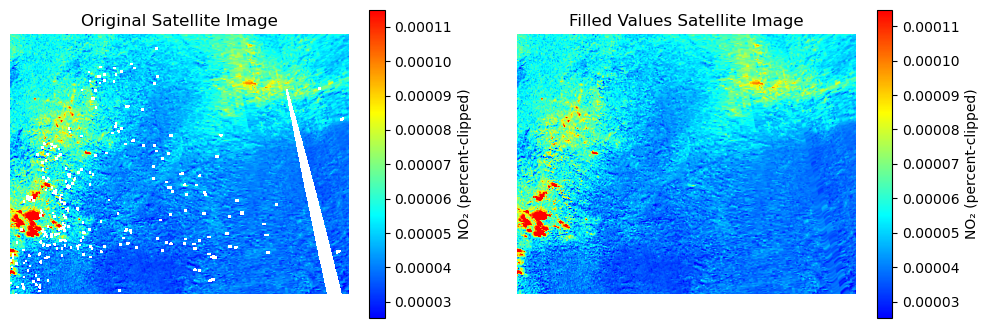

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot original image
src, band, profile, nodata_value = read_tiff(DEMO_PATH / 'Ethiopia_NO2_2023-01-01.tif')
plot_raster(band, percent_clip=0.5, ax=axes[0], title="Original Satellite Image")

# filled image
src, band_filled, profile, nodata_value = read_tiff(DEMO_PATH / 'Ethiopia_NO2_2023-01-01_filled.tif')
plot_raster(band_filled, percent_clip=0.5, ax=axes[1], title="Filled Values Satellite Image")

plt.show()

From the figure on the left, there are missing values in the plot, representing by the white small regions.  It is clear that the small missing parts in the original figure are filled perfectly.

#### Iraq

After processed the following cell, comment it.

In [ ]:
from missingvalue import fill_missing_data

iraq_tiff_path = DATA_PATH / 'Iraq-no2'
fill_missing_data('Iraq', data_tiff_path=iraq_tiff_path, output_path=DATA_PATH)

**Visualization**

Use *Iraq_NO2_2023-01-01.tif* file as an exmaple to show the results of filling missing value.

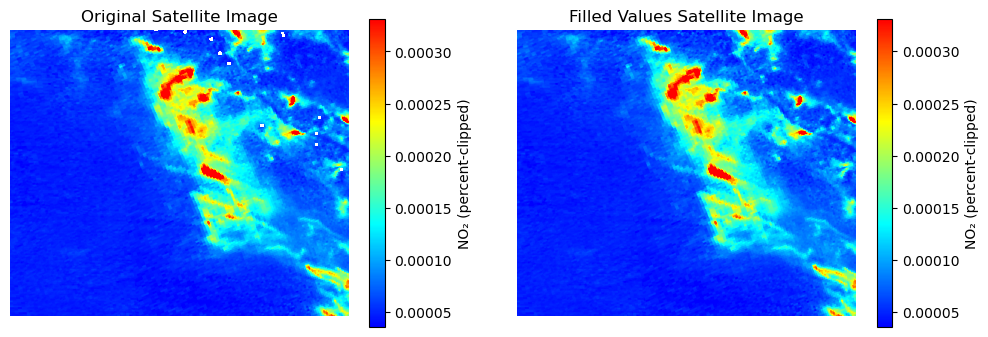

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot original image
src, band, profile, nodata_value = read_tiff(DEMO_PATH / 'Iraq_NO2_2023-01-01.tif')
plot_raster(band, percent_clip=0.5, ax=axes[0], title="Original Satellite Image")

# filled image
src, band_filled, profile, nodata_value = read_tiff(DEMO_PATH / 'Iraq_NO2_2023-01-01_filled.tif')
plot_raster(band_filled, percent_clip=0.5, ax=axes[1], title="Filled Values Satellite Image")

plt.show()

Similarly, the small missing value areas in upper right is filled perfectly. Thus, the iterative filling method can significantly enhance the data quality.

### 1.2 Aggregate Based on Mesh Grid

In [ ]:
from aggregation import*

addis_meshes_path = DATA_PATH / 'addis-mesh-data'
baghdad_meshes_path = DATA_PATH / 'baghdad-mesh-data'

mesh_addis = DATA_PATH / "mesh-grid" / "grid_addis_ababa.gpkg"
mesh_baghdad = DATA_PATH / "mesh-grid" / "grid_baghdad.gpkg"

lyr_addis_name = fiona.listlayers(mesh_addis)[0]         # control layer number = 1 
lyr_baghdad_name = fiona.listlayers(mesh_baghdad)[0]

#### Ethiopia - Addis Ababa

In [ ]:
# Aggregate Ethiopia - Addis Ababa
eth_no2_filled_path = DATA_PATH / 'Ethiopia-no2-filled'
aggregate_data(
    data_tiff_path=eth_no2_filled_path, 
    mesh_path=addis_meshes_path, 
    layer_name=lyr_addis_name
    )

**Visualization**

Show aggregated result in 2023-01-01 in Addis Ababa.

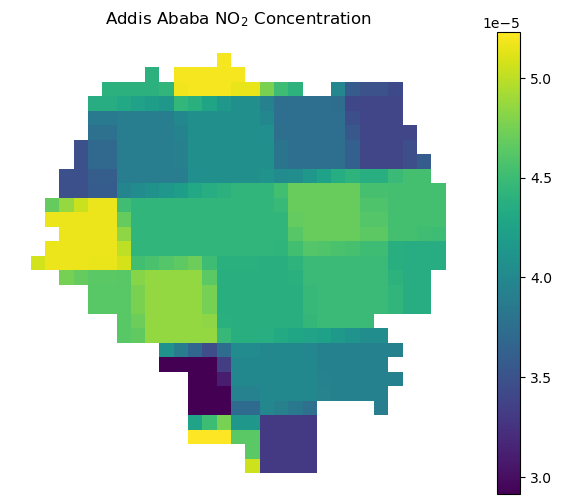

In [4]:
demo_mesh = gpd.read_file(DEMO_PATH / 'addis-ababa-2023-01-01.gpkg')
plot_mesh(mesh=demo_mesh, feature='no2_mean', title="Addis Ababa NO$_2$ Concentration", show_edges=False)
plt.show()

#### Iraq - Baghdad

In [ ]:
# Aggregate Iraq - Baghdad
iraq_no2_filled_path = DATA_PATH / 'Iraq-no2-filled'
aggregate_data(
    data_tiff_path=iraq_no2_filled_path, 
    mesh_path=baghdad_meshes_path, 
    layer_name=lyr_baghdad_name
    )

**Visualization**

Show aggregated result in 2023-01-01 in Baghdad.

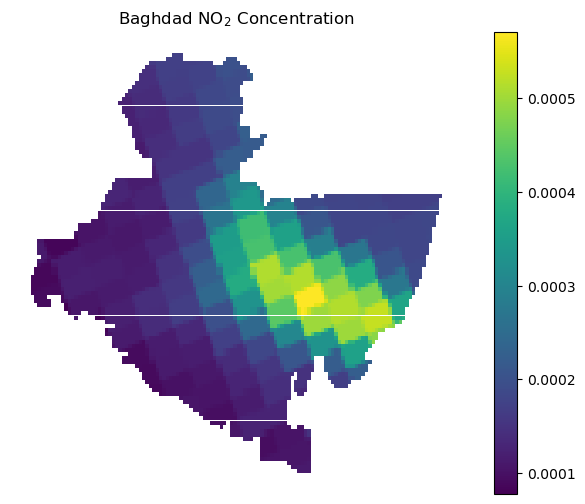

In [22]:
demo_mesh = gpd.read_file(DEMO_PATH / 'baghdad-2023-01-01.gpkg')
plot_mesh(mesh=demo_mesh, feature='no2_mean', title="Baghdad NO$_2$ Concentration", show_edges=False)
plt.show()

## 2 Data Visualisation

This chapter is used to generate a dynatmic figure, to show how the NO2 distribution changes over time.

Note:

- In the coloration system, percentile clipping and contrast streching method is uesd to imporve the visual effects of the image.

- In this chapter, the dynamic distribution of NO2 is generated, in format of GIF. 

### 2.1 Dynamic NO2 Distribution - Country Level

#### Ethiopia

Scanning percentiles: 100%|██████████| 131/131 [00:13<00:00,  9.96it/s]


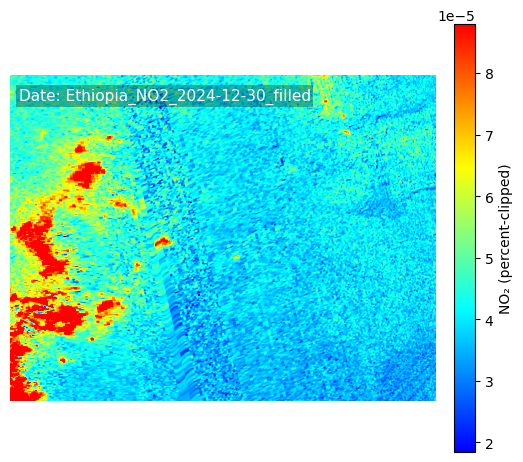

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\ethiopia-no2-animation.gif


In [ ]:
no2_eth_tif_dir = DATA_PATH / 'Ethiopia-no2-filled'  
tiff_2_gif(no2_eth_tif_dir, output_path=DATA_PATH, output_name="ethiopia-no2-animation", fps = 8)

#### Iraq

Scanning percentiles: 100%|██████████| 720/720 [00:38<00:00, 18.75it/s]


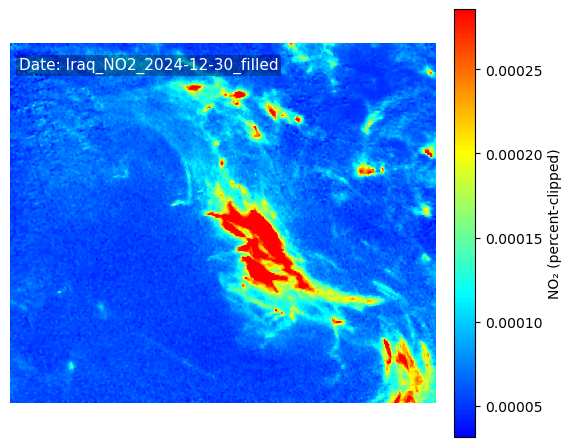

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\iraq-no2-animation.gif


In [8]:
no2_iraq_tif_dir= DATA_PATH / 'Iraq-no2-filled'  
tiff_2_gif(no2_iraq_tif_dir, output_path=DATA_PATH, output_name="iraq-no2-animation", fps = 8)

### 2.2 Dynamic NO2 Mesh - City Level

**Addis Ababa**

Scanning percentiles: 100%|██████████| 731/731 [00:07<00:00, 93.50it/s] 


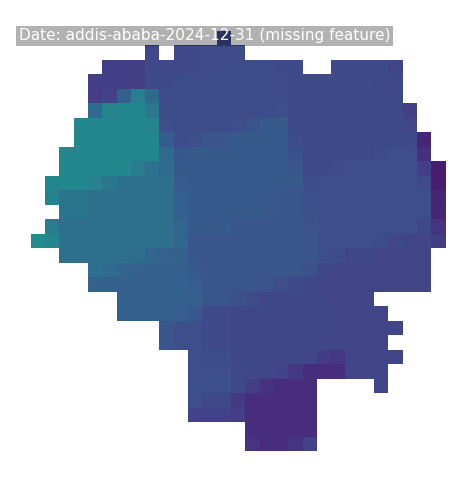

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\addis-ababa-no2-animation.gif


In [9]:
addis_gpkg_path = DATA_PATH / 'addis-mesh-data'

mesh_2_gif(
    gpkg_path=addis_gpkg_path, 
    output_path=DATA_PATH,
    output_name= "addis-ababa-no2-animation", 
    feature='no2_mean',
   )
plt.show()

**Baghdad**

Scanning percentiles: 100%|██████████| 731/731 [00:24<00:00, 30.02it/s]


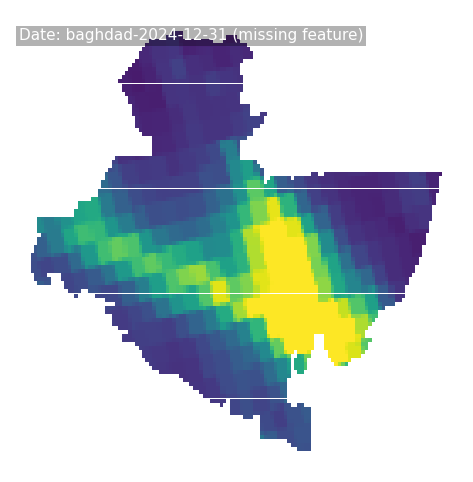

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\baghdad-no2-animation.gif


In [10]:
baghdad_gpkg_path = DATA_PATH / 'baghdad-mesh-data'

mesh_2_gif(
    gpkg_path=baghdad_gpkg_path, 
    output_path=DATA_PATH,
    output_name= "baghdad-no2-animation", 
    feature='no2_mean',
   )
plt.show()

## 3 Exploratory Data Analysis

### 3.1 Temporal Analysis

#### Note

**Addis Ababa**

In temporal analysis, we grouped days considering working schema from Ethiopia, including **Workdays**, **Weekends**.

- Type i - Workdays: Mon-Fri
- Type ii - Weekends: Fri-Sun

**Baghdad**

In temporal analysis, we grouped days considering working schema from Iraq **Mon-Tue-Wed**, **Fri-Sat**, **Thu-Sun**.

- Type i - Working days: Mon-Tue-Wed
- Type ii - Extended working days: Thu-Sun     
- Type iii - Weekends: Fri-Sat

Day type is encoded using *str* type.

In [10]:
import pandas as pd

# Read helper table
date_df = pd.read_csv(DATA_PATH / "helper-files" / "workday_type_2023_2024.csv", parse_dates=["Date"])
print(f'Helper Date Table:\n{date_df.head(3)}')

# Set Output path
output_path = DATA_PATH / "exploratory-data-analysis"

Helper Date Table:
        Date  Weekday Ethiopia_Workday_Type Iraq_Workday_Type
0 2023-01-01   Sunday              Weekends           Thu-Sun
1 2023-01-02   Monday              Workdays       Mon-Tue-Wed
2 2023-01-03  Tuesday              Workdays       Mon-Tue-Wed


#### Ethiopia - Addis Ababa

Calculate the average NO2 distribution in both workdays and weekends in Addis Ababa.

In [ ]:
addis_workday_average = compute_mean_mesh_by_daytype(
    date_df,
    output_path = output_path,
    feature_col = "no2_mean",
    output_name = "addis_ababa_workdays_weekends_no2_mesh.gpkg",
    meshes_path = DATA_PATH / "addis-mesh-data",
    country = "Ethiopia",
    city = "addis-ababa"
)


Saved mean meshes to D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\exploratory-data-analysis\addis_ababa_workdays_weekends_no2_mesh.gpkg


Compare the results in different workday types.

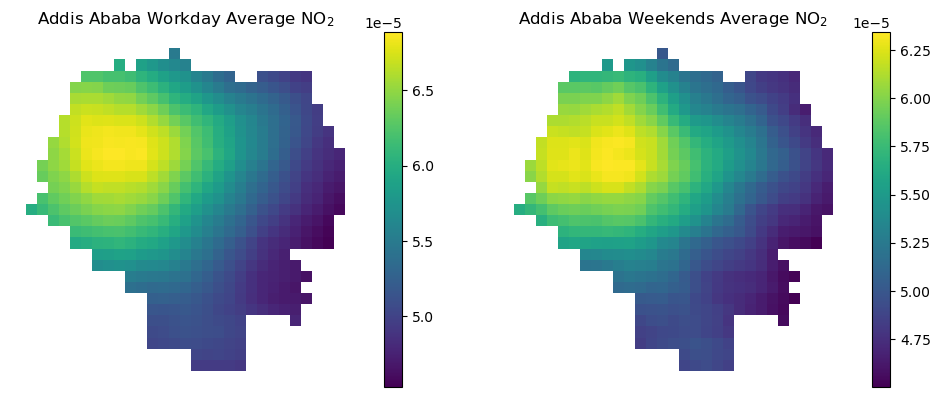

In [11]:
addis_workday_average = gpd.read_file(DEMO_PATH / "addis_ababa_workdays_weekends_no2_mesh.gpkg")
fig, axes = plt.subplots(1,2, figsize=(10, 4))
plot_mesh(addis_workday_average, "Workdays_mean", title="Addis Ababa Workday Average NO$_2$", ax = axes[0], show_edges=False, show=False)
plot_mesh(addis_workday_average, "Weekends_mean", title="Addis Ababa Weekends Average NO$_2$", ax = axes[1], show_edges=False, show=False)
plt.tight_layout()
plt.show()

#### Iraq - Baghadad

Calculate the average NO2 distribution in different days, from Monday to Sunday in Baghdad.

In [12]:
baghdad_workday_average = compute_mean_mesh_by_daytype(
    date_df,
    output_path = output_path,
    feature_col = "no2_mean",
    output_name = "baghdad_workdays_weekends_no2_mesh.gpkg",
    meshes_path = DATA_PATH / "baghdad-mesh-data",
    country = "Iraq",
    city = "baghdad"
)


Saved mean meshes to D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\exploratory-data-analysis\baghdad_workdays_weekends_no2_mesh.gpkg


Compare the results in different workday types, we have three in this Baghdad ('Mon-Tue-Wed', 'Fri-Sat' and 'Thu-Sun').

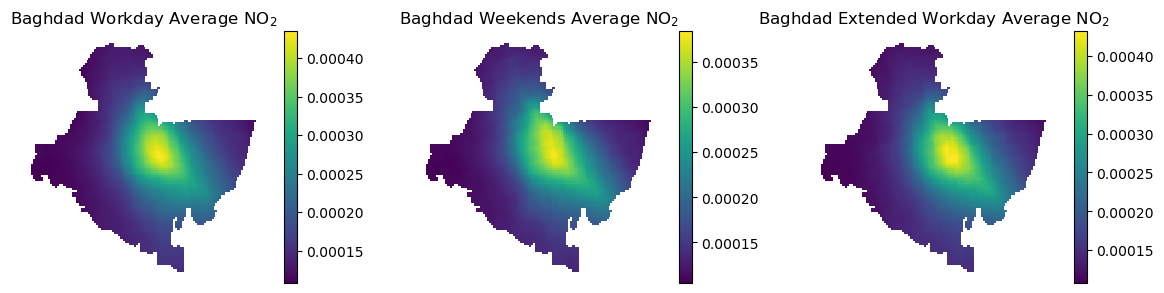

In [20]:
baghdad_workday_average = gpd.read_file(DEMO_PATH / "baghdad_workdays_weekends_no2_mesh.gpkg")
fig, axes = plt.subplots(1,3, figsize=(12, 3))
plot_mesh(baghdad_workday_average, "Mon-Tue-Wed_mean", title="Baghdad Workday Average NO$_2$", ax = axes[0], show_edges=False, show=False)
plot_mesh(baghdad_workday_average, "Thu-Sun_mean", title="Baghdad Extended Workday Average NO$_2$", ax = axes[2], show_edges=False, show=False)
plot_mesh(baghdad_workday_average, "Fri-Sat_mean", title="Baghdad Weekends Average NO$_2$", ax = axes[1], show_edges=False, show=False)
plt.tight_layout()
plt.show()

### 3.2 Spacial Analysis
#### Ethiopia - Addis Ababa

In [5]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

In [6]:
# Data paths and settings
data_folder = DATA_PATH / "addis-ababa-no2-mesh" 
shapefile_path = DATA_PATH / "city-boundary/addis-ababa/addis-ababa-adm3.shp"
output_folder = DATA_PATH / "addis-ababa-time-series-plots"
os.makedirs(output_folder, exist_ok=True)

/var/folders/5f/4xtp460569d8xfc5ygcs9w500000gp/T/ipykernel_12874/1051972508.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(time_series_data)


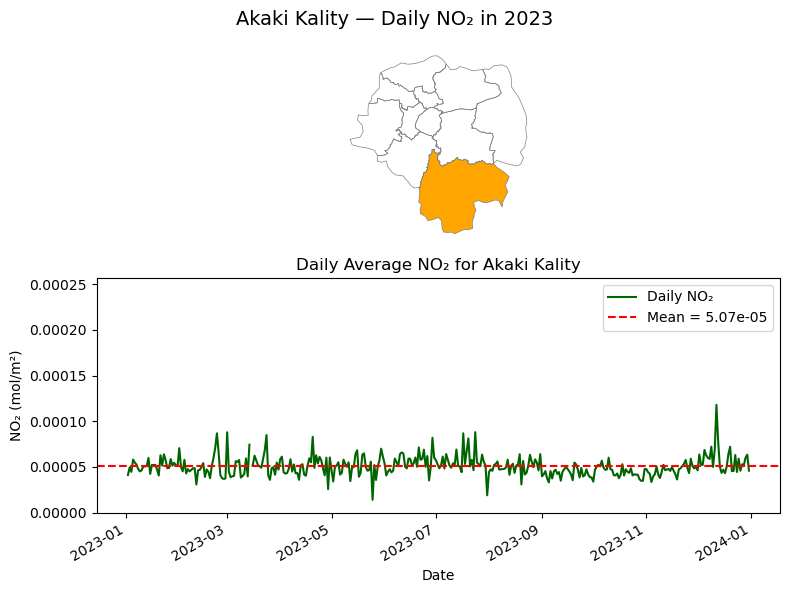

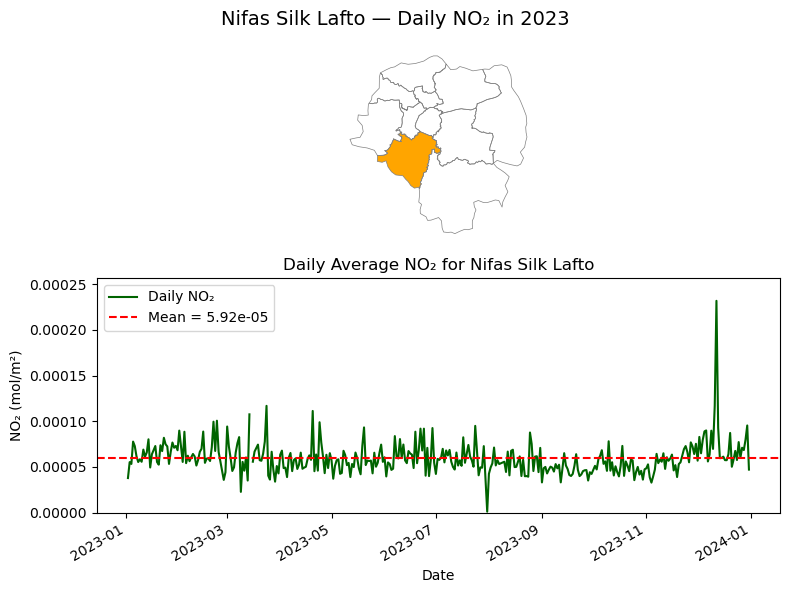

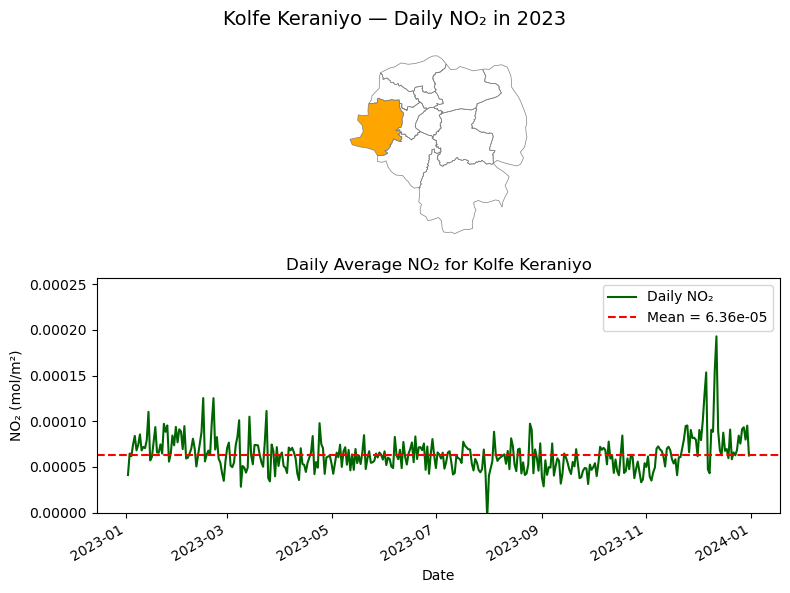

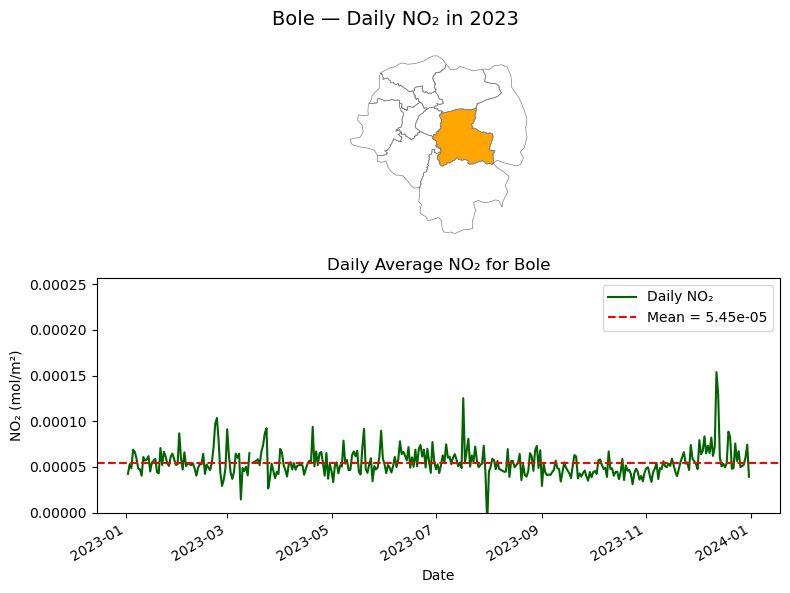

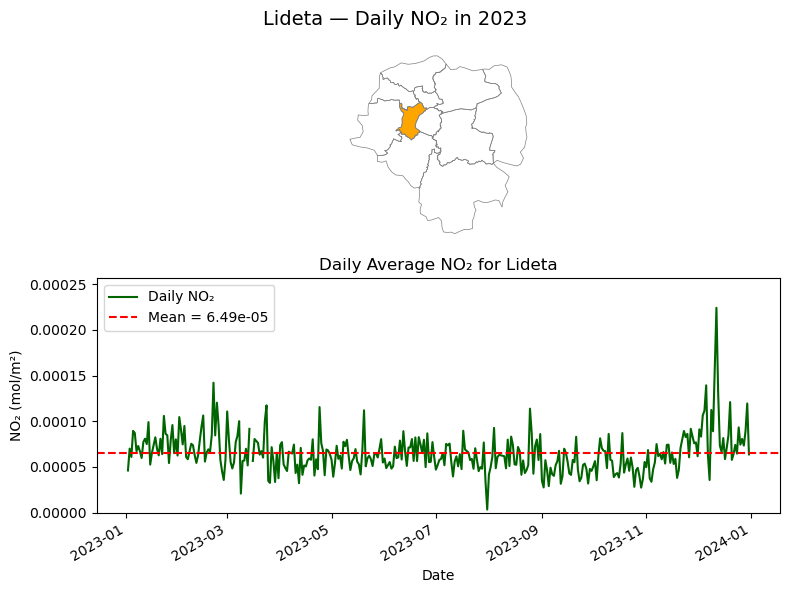

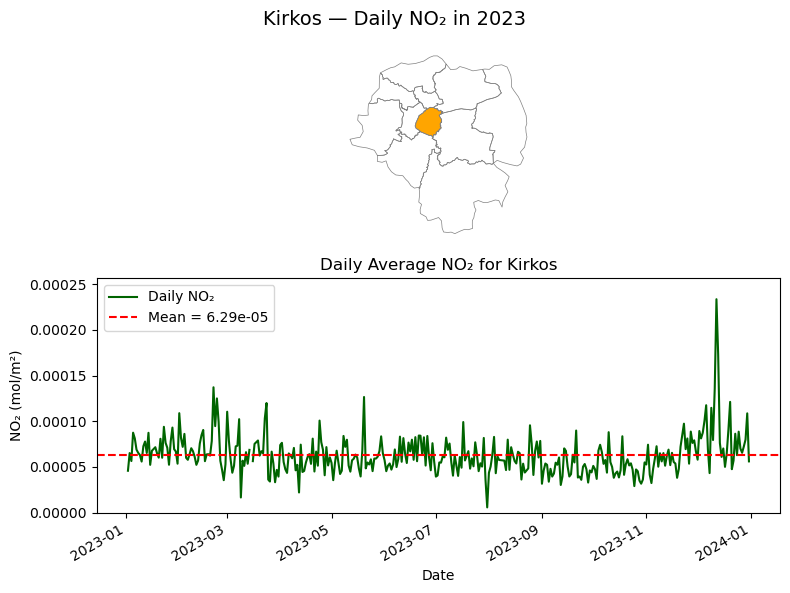

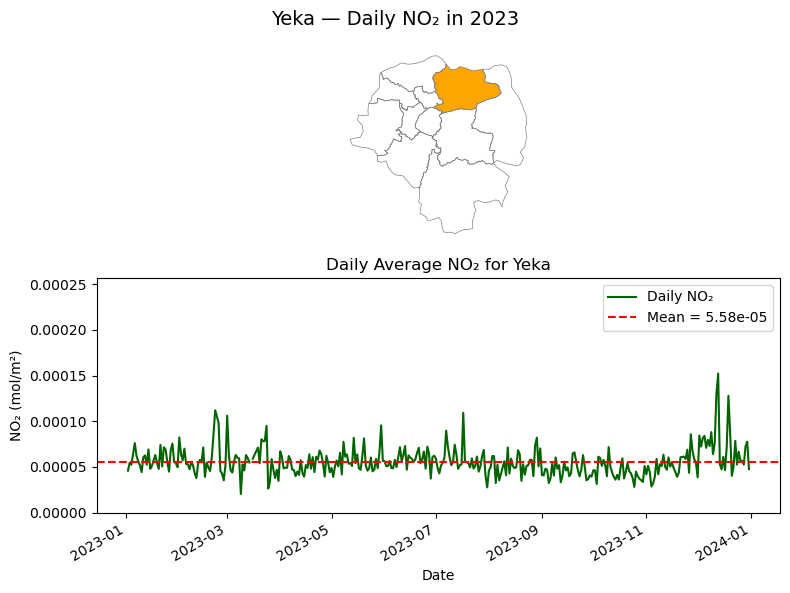

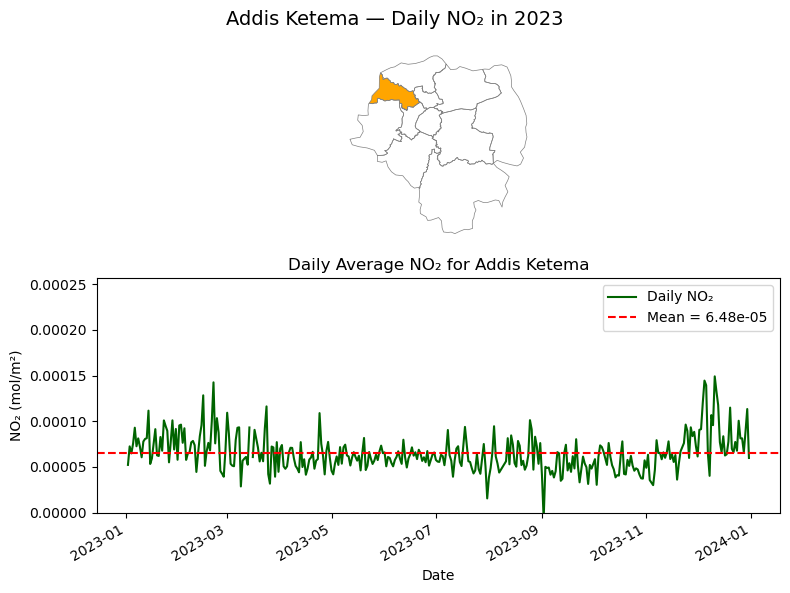

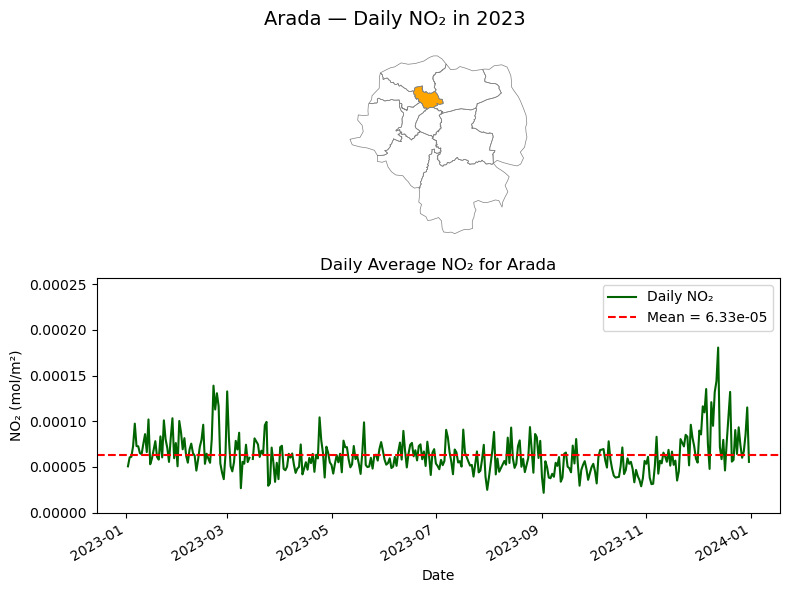

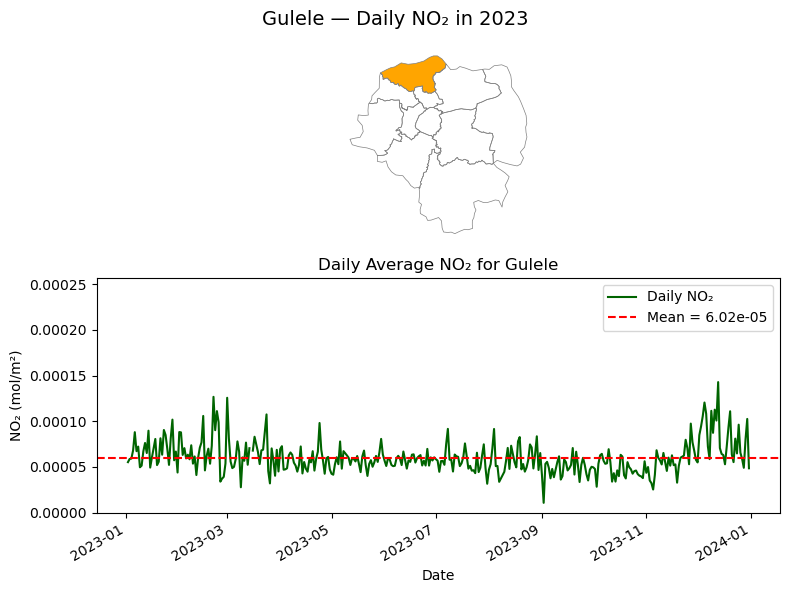

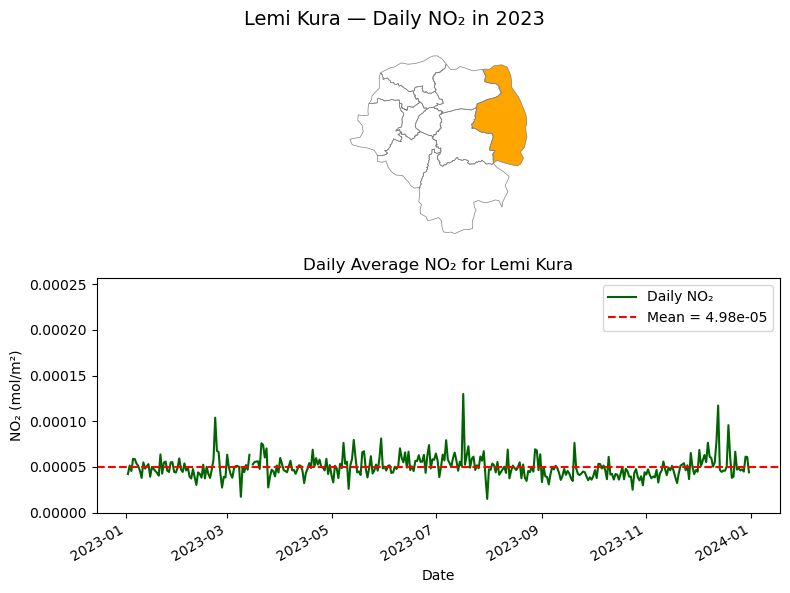

In [7]:
# Load administrative boundary
adm3 = gpd.read_file(shapefile_path).to_crs(epsg=4326)
adm3 = adm3.reset_index(drop=True).reset_index().rename(columns={"index": "adm_id"})

# Initialize an empty list to collect daily NO2 averages
time_series_data = []

# Loop through daily GPKG files and calculate mean NO2 for each ADM3 zone
for f in sorted(os.listdir(data_folder)):
    if not f.endswith(".gpkg") or not f.startswith("addis-ababa-2023"):
        continue

    date_str = f.split("addis-ababa-")[1].replace(".gpkg", "")
    try:
        date = datetime.strptime(date_str, "%Y-%m-%d")
    except:
        continue

    gdf = gpd.read_file(os.path.join(data_folder, f))
    if gdf.empty or "no2_mean" not in gdf.columns:
        continue

    gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]
    gdf = gdf.dropna(subset=["no2_mean"])
    gdf = gdf.to_crs(adm3.crs)

    joined = gpd.sjoin(gdf, adm3, how="inner", predicate="intersects")
    daily_avg = joined.groupby("adm_id")["no2_mean"].mean().reset_index()
    daily_avg["date"] = date
    time_series_data.append(daily_avg)

# panel-format dataframe
df_all = pd.concat(time_series_data)
pivot_df = df_all.pivot(index="date", columns="adm_id", values="no2_mean")


# Calculate overall max NO₂ value across all zones to standardize y-axis
ymax = pivot_df.max().max()

# Plot the first 11 ADM3 zones
for adm_id in pivot_df.columns[:11]:
    adm_name = adm3.loc[adm3.adm_id == adm_id, "ADM3_EN"].values[0]
    series = pivot_df[adm_id]

    fig, (ax_map, ax_line) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [1, 1.2]})
    fig.suptitle(f"{adm_name} — Daily NO₂ in 2023", fontsize=14)

    # Top subplot: map with the selected ADM3 zone highlighted
    adm3.boundary.plot(ax=ax_map, linewidth=0.5, edgecolor="gray")
    adm3.loc[adm3.adm_id == adm_id].plot(ax=ax_map, color="orange")
    ax_map.axis("off")

    # Bottom subplot: time series with mean line
    series.plot(ax=ax_line, color="darkgreen", label="Daily NO₂")
    mean_val = series.mean()
    ax_line.axhline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2e}")

    ax_line.set_ylabel("NO₂ (mol/m²)")
    ax_line.set_xlabel("Date")
    ax_line.set_ylim(0, ymax * 1.1)
    ax_line.set_title(f"Daily Average NO₂ for {adm_name}")
    ax_line.legend()

    plt.tight_layout()
    plt.show()

    # Save figure to file
    out_path = os.path.join(output_folder, f"{adm_name.replace(' ', '_')}.png")
    fig.savefig(out_path, dpi=100)
    plt.close()


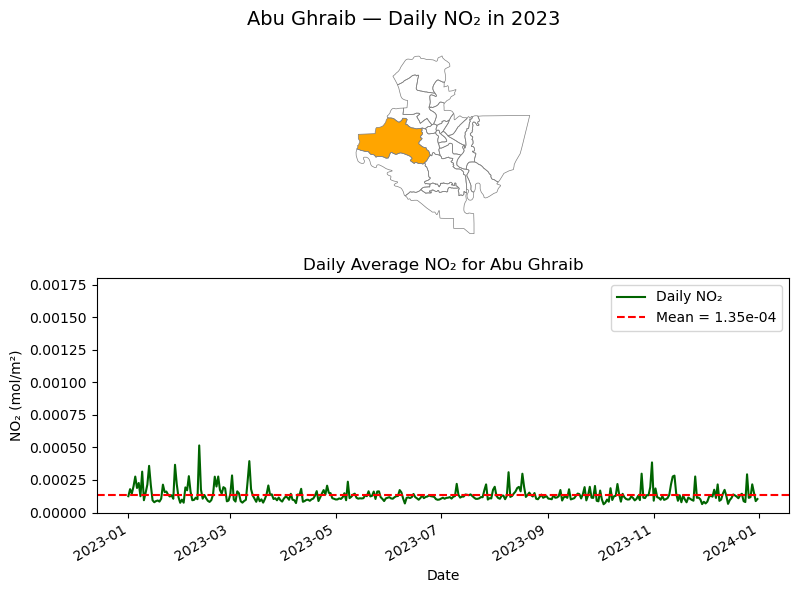

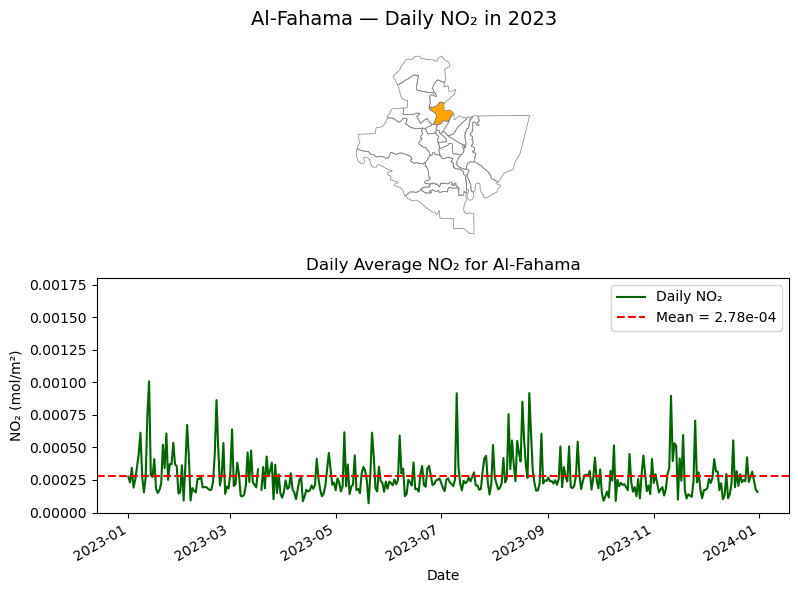

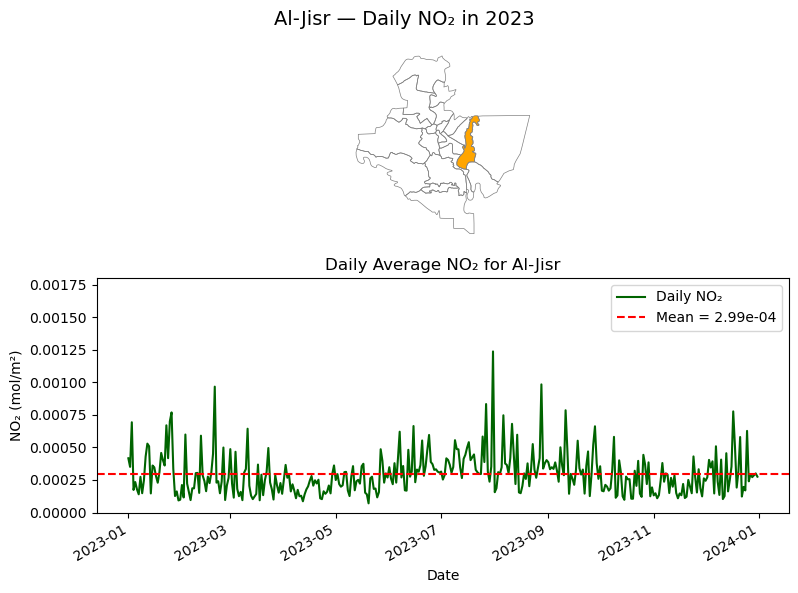

In [8]:
# Data paths and settings
data_folder = DATA_PATH / "baghdad-no2-mesh"
shapefile_path = DATA_PATH / "city-boundary/baghdad/baghdad-adm3.shp"
output_folder = DATA_PATH / "baghdad-time-series-plots"
output_folder.mkdir(parents=True, exist_ok=True)

# Load administrative boundary
adm3 = gpd.read_file(shapefile_path).to_crs(epsg=4326)
adm3 = adm3.reset_index(drop=True).reset_index().rename(columns={"index": "adm_id"})

# Initialize an empty list to collect daily NO2 averages
time_series_data = []

# Loop through daily GPKG files and calculate mean NO2 for each ADM3 zone
for f in sorted(os.listdir(data_folder)):
    if not f.endswith(".gpkg") or not f.startswith("baghdad-2023"):
        continue

    date_str = f.split("baghdad-")[1].replace(".gpkg", "")
    try:
        date = datetime.strptime(date_str, "%Y-%m-%d")
    except:
        continue

    gdf = gpd.read_file(data_folder / f)
    if gdf.empty or "no2_mean" not in gdf.columns:
        continue

    gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]
    gdf = gdf.dropna(subset=["no2_mean"])
    gdf = gdf.to_crs(adm3.crs)

    joined = gpd.sjoin(gdf, adm3, how="inner", predicate="intersects")
    daily_avg = joined.groupby("adm_id")["no2_mean"].mean().reset_index()
    daily_avg["date"] = date
    time_series_data.append(daily_avg)

# panel-format dataframe
df_all = pd.concat(time_series_data)
pivot_df = df_all.pivot(index="date", columns="adm_id", values="no2_mean")

# Calculate overall max NO₂ value across all zones to standardize y-axis
ymax = pivot_df.max().max()

# Plot ADM3 zones
for i, adm_id in enumerate(pivot_df.columns):
    adm_name = adm3.loc[adm3.adm_id == adm_id, "ADM3_EN"].values[0]
    series = pivot_df[adm_id]

    fig, (ax_map, ax_line) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [1, 1.2]})
    fig.suptitle(f"{adm_name} — Daily NO₂ in 2023", fontsize=14)

    # Top subplot: map
    adm3.boundary.plot(ax=ax_map, linewidth=0.5, edgecolor="gray")
    adm3.loc[adm3.adm_id == adm_id].plot(ax=ax_map, color="orange")
    ax_map.axis("off")

    # Bottom subplot: time series
    series.plot(ax=ax_line, color="darkgreen", label="Daily NO₂")
    mean_val = series.mean()
    ax_line.axhline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2e}")

    ax_line.set_ylabel("NO₂ (mol/m²)")
    ax_line.set_xlabel("Date")
    ax_line.set_ylim(0, ymax * 1.1)
    ax_line.set_title(f"Daily Average NO₂ for {adm_name}")
    ax_line.legend()

    plt.tight_layout()

    if i < 3:
        plt.show()
    else:
        out_path = output_folder / f"{adm_name.replace(' ', '_')}.png"
        fig.savefig(out_path, dpi=100)
        plt.close()


###